<a href="https://colab.research.google.com/github/dohyeonkim2526/DataEngineering-Ability/blob/master/Home_Credit_Default_Risk_Competition_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
app_train=pd.read_csv('/content/drive/My Drive/Kaggle Study/data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test=pd.read_csv('/content/drive/My Drive/Kaggle Study/data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# EDA (Exploratory Data Analysis)

In [52]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

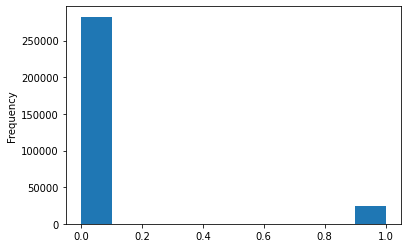

In [53]:
app_train['TARGET'].astype(int).plot.hist()

불균형 클래스 문제

*   대출 상환 가능(0), 상환 어려움(1)
*   대출 상환 가능한 사람이 훨씬 더 많다.
*   클래스 불균형 문제를 해결하기 위해서 각 클래스에 '가중치'를 부여할 것이다.



In [5]:
def missing_values_table(df):
  mis_val=df.isnull().sum()
  mis_val_percent=100*df.isnull().sum()/len(df)

  mis_val_table=pd.concat([mis_val, mis_val_percent], axis=1)
  mis_val_table_ren_columns=mis_val_table.rename(columns={0:'Missing Values', 1:'% of Total Values'})

  mis_val_table_ren_columns=mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)

  print("Your selected dataframe has " + str(df.shape[1]) + "columns.\n"
      "There are " + str(mis_val_table_ren_columns.shape[0])+" columns that have missing values.")
  
  return mis_val_table_ren_columns

In [6]:
missing_values=missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


결측값 처리


*   결측값이 많은 column을 제거하는 것이 일반적이지만, 해당 column이 도움이 될 수 있으므로 우선 제거하지 않는다.
*   우리는 결측값을 채우지 않고 처리해주는 XGBoost와 같은 모델을 사용할 것이다.



In [57]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

각 컬럼에서 카테고리형 변수(object)가 매우 적으므로 카테고리형 변수를 처리해준다.

#Encoding Categorical Variables

일반적으로 머신 러닝 모델은 범주형 변수를 처리할 수 없다.(LightGBM 같은 모델 제외)

그래서 범주형 변수를 숫자로 표현하는 방법을 이용해야 한다.


1.   Label Encoding: 범주형 변수를 숫자 정수로 바꿔준다.

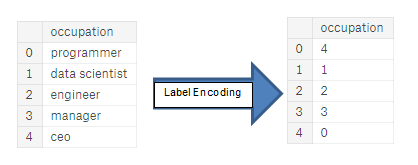


2.   One-Hot Encoding: 0과 1로 이루어진 숫자로 만들어준다.

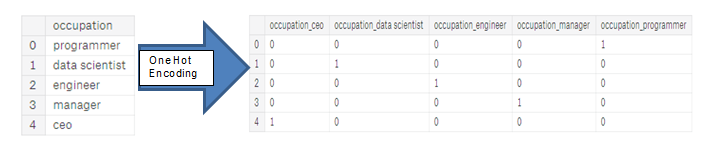





*  Label Encoding 문제점

  - 숫자가 부여되는 방식이 무작위이다.
  - 처음에는 (1: 사과, 2: 바나나, 3: 포도)로 바뀌지만 다음 수행 시에는 (1: 포도, 2: 사과, 3: 바나나)처럼 완전히 달라질 수 있다.
  - 범주가 2개인 경우(남성,여성)에는 사용할 수 있지만 2개 이상인 경우에는 One-Hot Encoding을 사용한다.


* One-Hot Encoding 문제점
  - 무작위로 바뀌는 Label Encoding과 달리 항상 동일하므로 안전하다.
  - 그러나 데이터의 개수가 많아지면 과부하(=폭발)될 수 있다.
  - 그래서 One-Hot Encoding을 수행하고 PCA 등을 이용하여 차원 축소 방법을 사용해준다.

이 분석 문제에서는 범주가 2개면 Label Encoding을 하고, 2개 이상이면 One-Hot Encoding을 해줄 것이다.


In [8]:
le=LabelEncoder()
le_count=0

for col in app_train:
  if app_train[col].dtype=='object':
    if len(list(app_train[col].unique()))<=2:
      le.fit(app_train[col])
      app_train[col]=le.transform(app_train[col])
      app_test[col]=le.transform(app_test[col])
      le_count+=1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [9]:
app_train=pd.get_dummies(app_train)
app_test=pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [10]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


# EDA-Anomalies(이상현상)


*   데이터 분석을 할 때 숫자에 대한 이상치를 처리하는 것이 매우 중요하기 때문에 **describe** 메서드를 이용하여 확인한다.
*   이 데이터에서는 'DAYS_BIRTH'(출생일)이 대출 신청날로부터 측정되어서 음수 값을 가지게 된다.
*   이를 처리하기 위해서 -1을 곱하고, 1년의 일수로 나눠준다.




In [76]:
(app_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [77]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

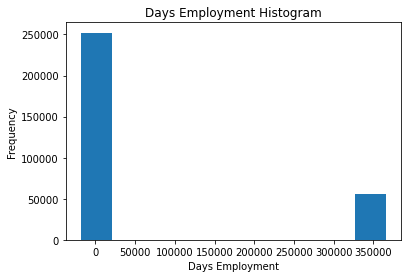

In [79]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [13]:
anom=app_train[app_train['DAYS_EMPLOYED']==365243]
non_anom=app_train[app_train['DAYS_EMPLOYED']!=365243]
print('The non-anomalies default on %0.2f%% of loans' % (100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100*anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5, 0, 'Days Employment')

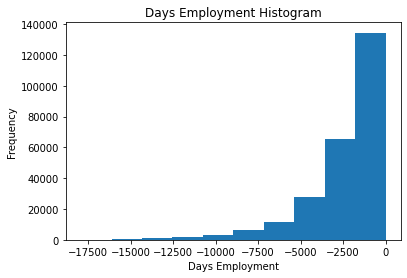

In [14]:
app_train['DAYS_EMPLOYED_ANOM']=app_train['DAYS_EMPLOYED']==365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [15]:
app_test['DAYS_EMPLOYED_ANOM']=app_test['DAYS_EMPLOYED']==365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


# Correlation(상관관계)


*  변수 간의 상관관계를 알기 위해서 **Pearson** 계수를 사용한다.
*  상관 계수 해석

    *   0 ~ 0.2 : 매우 약함
    *   0.2 ~ 0.4 : 약함
    *   0.4 ~ 0.6 : 보통
    *   0.6 ~ 0.8 : 강함
    *   0.8 ~ 1.0 : 매우 강함





In [16]:
correlations=app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

강한 상관관계를 보이는 변수는 'DAYS_BIRTH(나이)'이다.
(종속 변수 'TARGET'의 상관관계는 항상 1이므로 무시한다.)

그런데 'DAYS_BIRTH'는 음수 값이므로 절대값을 취해서 상관관계를 다시 확인한다.

In [17]:
app_train['DAYS_BIRTH']=abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

음의 선형 관계 -0.078

  * 고객의 나이가 증가할수록 TARGET은 0이 많다. (상환을 잘한다)
  * = 고객의 나이가 감소할수록 TARGET은 1이 많다. (상환을 잘 하지 못한다)

즉, 고객의 나이가 많을수록 대출 상환을 잘한다는 것을 알 수 있다. 이를 직접적으로 확인하기 위해 히스토그램을 이용해보자.

Text(0, 0.5, 'Count')

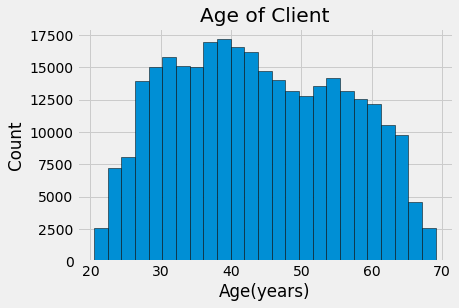

In [15]:
plt.style.use('fivethirtyeight')
plt.hist(app_train['DAYS_BIRTH']/365, edgecolor='k', bins=25)
plt.title('Age of Client'); plt.xlabel('Age(years)'); plt.ylabel('Count')

일반 히스토그램 만으로는 연령대의 분포밖에 확인할 수 없다.

그러므로 KDE(커널 밀도 추정) 그래프를 그려서 TARGET 분포를 확인해보자.

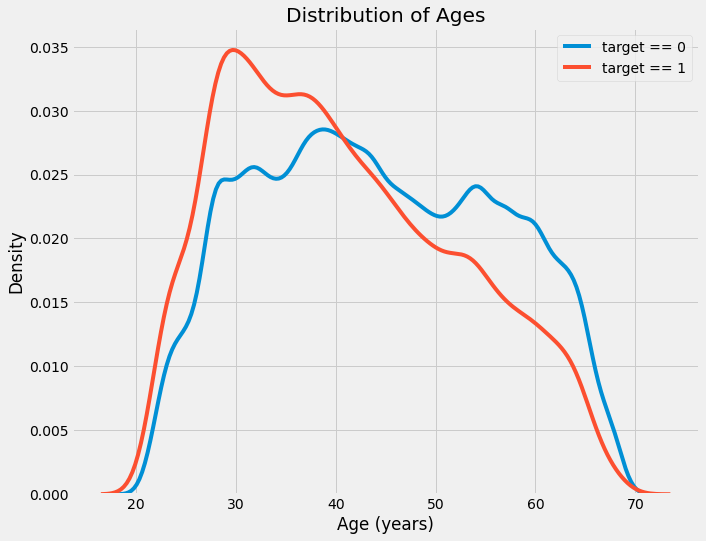

In [19]:
plt.figure(figsize = (10, 8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
plt.legend()
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Target=1(상환 불가능) 곡선이 연령대가 낮은 쪽으로 기울어져 있다.

연령('DAYS_BIRTH')과 종속변수의 상관관계가 -0.078로 높은 것은 아니지만 어느정도 영향이 있다고 느껴진다.

그래서 연령대별로 대출 상환이 어려운 비율을 보기 위해서 먼저 연령대를 5년 단위로 나눠준다.

In [18]:
age_data=app_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20,70,num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [19]:
age_groups=age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

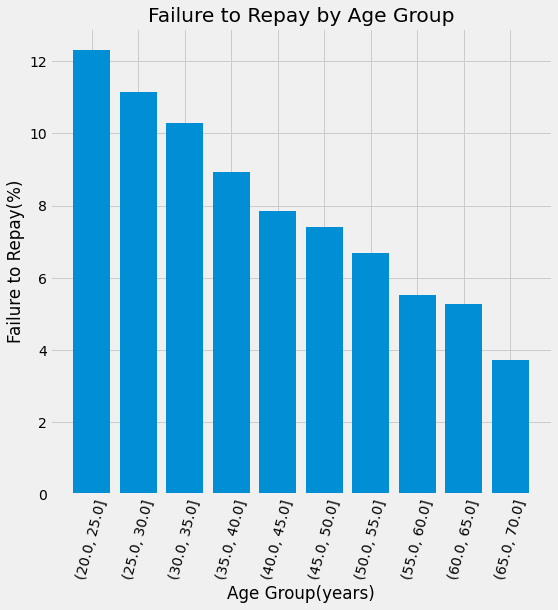

In [26]:
plt.figure(figsize=(8,8))
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])
plt.xticks(rotation=75); plt.xlabel('Age Group(years)'); plt.ylabel('Failure to Repay(%)')
plt.title('Failure to Repay by Age Group')

TARGET(1): 상환 어려움 / TARGET(0): 상환 가능함

연령대별 TARGET의 평균


*   0에 가까움 ➡️ 상환 가능한 사람이 많음 ➡️ 연체율이 낮음
*   1에 가까움 ➡️ 상환 어려운 사람이 많음 ➡️ 연체율이 높음



그래프를 보면 연령대가 낮은 3그룹(20~35세)은 연체율이 모두 10% 이상이고, 연령대가 가장 높은 그룹(65-70세)는 연체율이 5% 미만이다.

따라서, 젊은 고객이 대출 상환을 못할 가능성이 많다는 사실이 밝혀졌다. 그러므로 은행에서는 향후 이들을 위한 재무 계획이나 지침을 세우는 것을 권고한다.

*가장 강한 음의 상관관계

상관관계 결과를 보면 EXT_SOURE_1, EXT_SOURCE_2, EXT_SOURCE_3이 가장 강한 음의 상관관계를 가지고 있다.

데이터 설명에서 해당 변수의 의미를 정확히 파악하긴 어렵지만, 일종의 누적 신용 등급을 나타낼 수 있다.

먼저, 해당 변수들 간의 상관관계를 살펴보자.

In [20]:
ext_data=app_train[['TARGET','EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corr=ext_data.corr()
ext_data_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

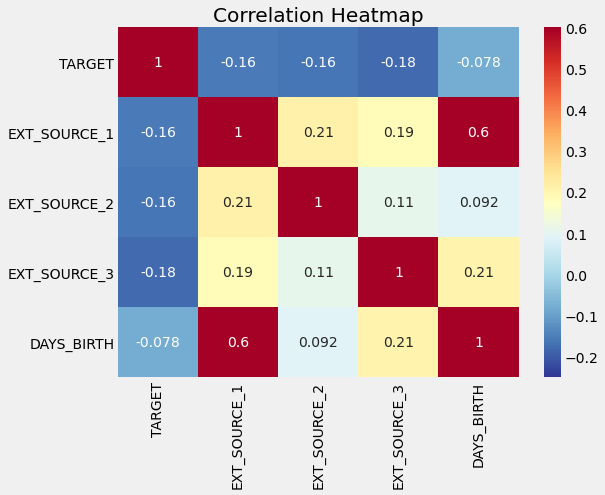

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(ext_data_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

EXT_SOURCE와 TARGET의 상관관계


*   모든 상관관계가 음수이다.
*   EXT_SOURCE가 증가할수록 TARET은 0에 가까워진다.(=상환 가능성이 높아진다.)



EXT_SOURCE_1와 DAYS_BIRTH의 상관관계


*   0.6으로 양의 상관관계가 있음을 확인할 수 있다.
*   이는 EXT_SOURCE_1 변수를 만들 때에 고객의 연령(DAYS_BIRTH)을 이용했을 가능성이 있음을 보여준다.


그럼, EXT_SOURCE 변수들과 TARGET 변수 관계를 시각화해보자.





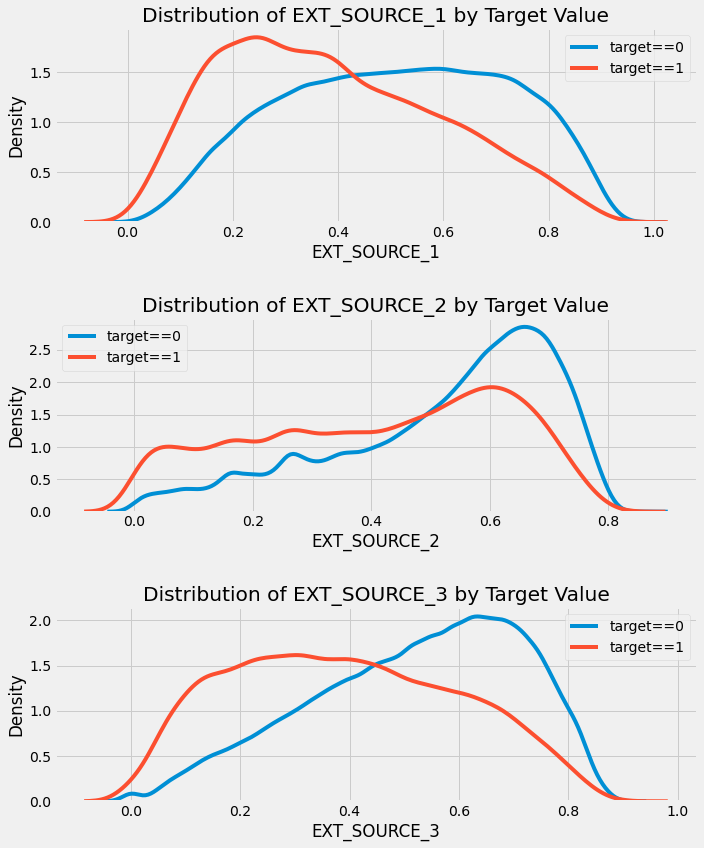

In [35]:
plt.figure(figsize=(10,12))

for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
  plt.subplot(3,1,i+1)
  sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label='target==0')
  sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label='target==1')
  plt.legend()
  plt.title('Distribution of %s by Target Value' % source)
  plt.xlabel('%s'%source); plt.ylabel('Density');

plt.tight_layout(h_pad=2.5)

시각화 결과를 보면, EXT_SOURCE_3이 유독 target의 분포가 다르다는 것을 확인할 수 있다. 

매우 약한 상관관계일 수 있지만, 해당 변수가 대출 상환 여부에 영향을 줄 수 있다는 가능성은 아직 배제할 수 없다.

Pair plot 메서드를 사용해서 변수들의 분포를 한번 더 시각화해보자.

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

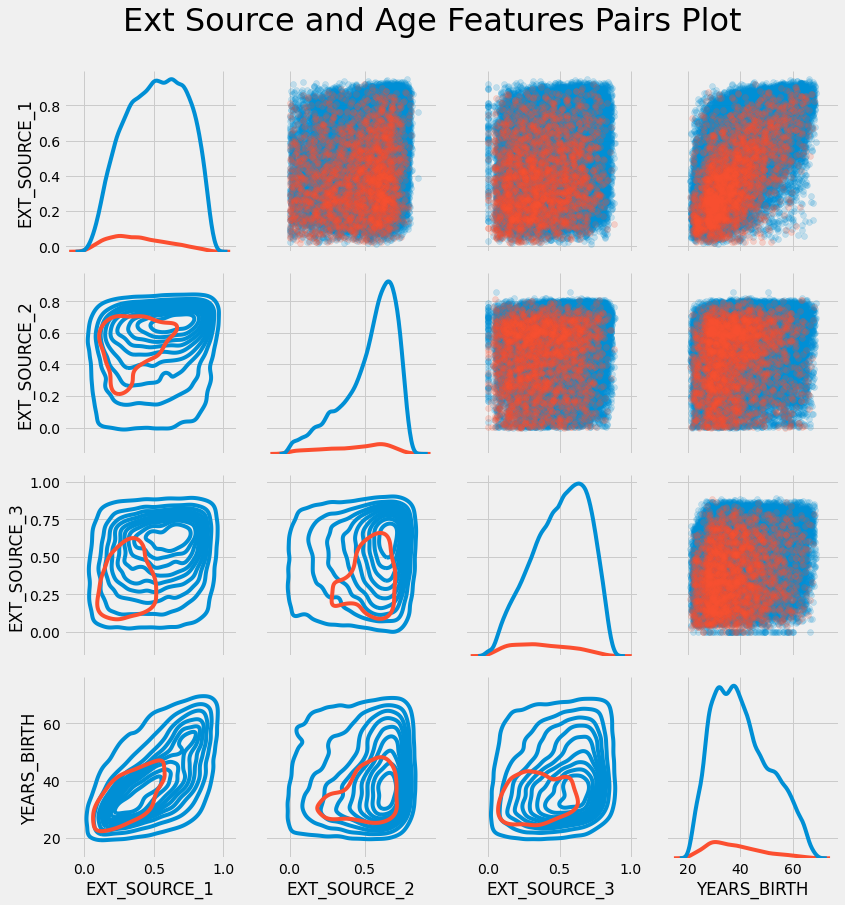

In [39]:
plot_data=ext_data.drop(columns=['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH']=age_data['YEARS_BIRTH']
plot_data=plot_data.dropna().loc[:100000,:]

def corr_func(x,y,**kwargs):
  r=np.corrcoef(x,y)[0][1]
  ax=plt.gca()
  ax.annotate("r={:.2f}".format(r),
              xy=(.2, .8), xycoords=ax.transAxes,
              size=20)
  
grid=sns.PairGrid(data=plot_data, size=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])
  
grid.map_upper(plt.scatter, alpha=0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)
plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)
  

위에서 **corr** 메서드로 상관관계를 수치화했을 때에 EXP_SOURCE_1과 DAYS_BIRTH가 양의 상관관계가 있음을 확인했다.

**pair plot**메서드로 분포를 시각화해본 결과, 양의 선형 상관 관계가 있음을 명확하게 볼 수 있었다. 

이에 따라, EXP_SOUCE_1 변수가 고객의 연령(DAYS_BIRTH) 변수를 이용했다고 말할 수 있다.


*참고로 YEARS_BIRTH는 DAYS_BIRTH와 동일하게 연령을 나타내는 변수이다.

# Feature Engineering
## *  Polynomial Features

만약 두 개의 변수가 있을 때에 각 변수들은 TARGET(종속변수)에 큰 영향을 미치지 않을 수 있다.

그러나 두 변수들의 결합시켰을 때는 어떤 상호작용에 의해서 TARGET에 큰 영향을 미칠 수도 있다.

머신 러닝 모델에서는 자주 사용되진 않지만 그래도 한번 확인해보자.


In [ ]:
#!pip install python-qt

In [ ]:
#!pip install Imputer

In [21]:
poly_features=app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH', 'TARGET']]
poly_features_test=app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

#from sklearn.preprocessing import Imputer
#imputer=Imputer(strategy='median')

from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')

poly_target=poly_features['TARGET']
poly_features=poly_features.drop(columns=['TARGET'])

poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
poly_transformer=PolynomialFeatures(degree=3)

In [22]:
poly_transformer.fit(poly_features)

poly_features=poly_transformer.transform(poly_features)
poly_features_test=poly_transformer.transform(poly_features_test)
print('Polynomial Features shapel: ', poly_features.shape)

Polynomial Features shapel:  (307511, 35)


In [23]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [24]:
poly_features=pd.DataFrame(poly_features, 
                           columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','URCE_3','DAYS_BIRTH']))

poly_features['TARGET']=poly_target
poly_corrs=poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 URCE_3         -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 URCE_3                      -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
URCE_3     -0.078239
URCE_3^2   -0.076672
URCE_3^3   -0.074273
TARGET      1.000000
1                NaN
Name: TARGET, dtype: float64


새로 만든 변수들의 상관관계를 살펴본 결과, 기존 상관관계 보다 더 큰 관계성을 보이는 변수들이 존재함을 볼 수 있다.

이후 모델 개발 과정에서 기존 데이터와 새로운 변수를 추가한 데이터들에 대한 성능을 비교해 볼 것이다.

In [25]:
poly_features_test=pd.DataFrame(poly_features_test,
                                columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

poly_features['SK_ID_CURR']=app_train['SK_ID_CURR']
app_train_poly=app_train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test['SK_ID_CURR']=app_test['SK_ID_CURR']
app_test_poly=app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

app_train_poly, app_test_poly=app_train_poly.align(app_test_poly, join='inner', axis=1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape: ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 259)
Testing data with polynomial features shape:  (48744, 259)


## * Domain Knowledge Features

우리는 신용 전문가가 아니라서 금융에 대한 지식이 부족하다.

그래서 아래의 4개 (금융적)지표를 참고하여서 대출 여부와의 관계를 확인해볼 것이다.



*   CREDIT_INCOME_PERCENT: 소득에 대한 신용장금액
*   ANNUITY_INCOME_PERCENT: 소득에 대한 연대출 비율
*   CREDIT_TERM: 지불 기간
*   DAYS_EMPLOYED_PERCENT: 연령에 대한 고용일




In [40]:
app_train_domain=app_train
app_test_domain=app_test

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [41]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

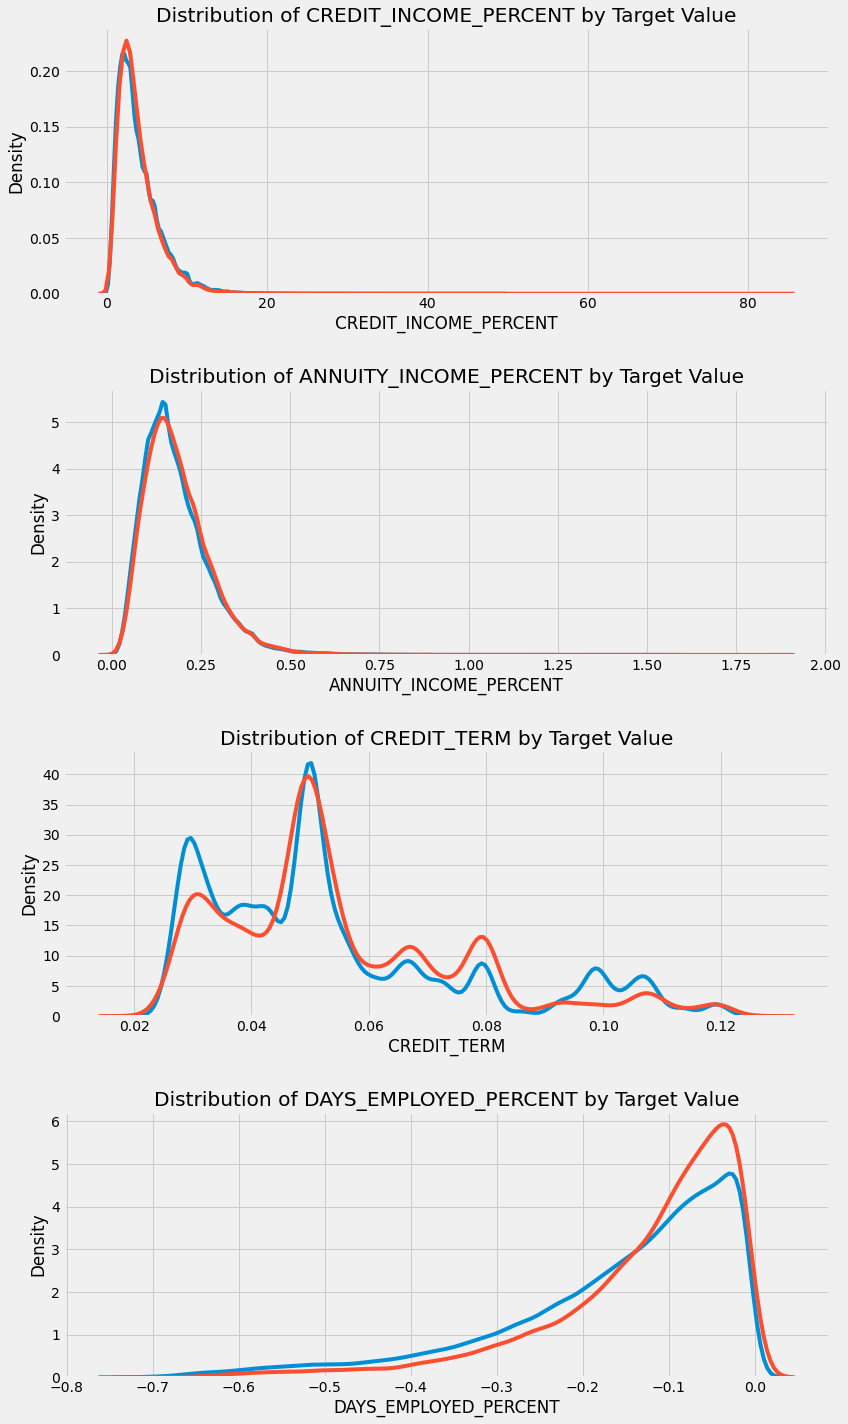

In [59]:
plt.figure(figsize=(12,20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

  plt.subplot(4,1,i+1)
  sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0, feature], label='target==0')
  sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1, feature], label='target==1')

  plt.title('Distribution of %s by Target Value' % feature)
  plt.xlabel('%s'%feature); plt.ylabel('Density');

plt.tight_layout(h_pad=2.5)

KDE plot 그래프 만으로는 새로운 지표가 유용하다고 판단하긴 어려운 것 같다.

# 예측 모델 개발
## 1. Logistic Regression

모델에 적용하기 전에 먼저 MinMaxScaler 정규화 통해 데이터 전처리를 수행해보자.

In [42]:
from sklearn.preprocessing import MinMaxScaler

if 'TARGET' in app_train:
  train=app_train.drop(columns='TARGET')

else:
  train=app_train.copy()

features=list(train.columns)
test=app_test.copy()

imputer=SimpleImputer(strategy='median')
#imputer=Imputer(strategy='median')
scaler=MinMaxScaler(feature_range=(0,1))
imputer.fit(train)

train=imputer.transform(train)
test=imputer.transform(app_test)

scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 244)
Testing data shape:  (48744, 244)


In [29]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(C=0.0001)

In [30]:
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
log_reg.predict_log_proba(test)

array([[-0.08363895, -2.52277399],
       [-0.15349509, -1.94985274],
       [-0.08886321, -2.46475967],
       ...,
       [-0.08301254, -2.52998276],
       [-0.08846041, -2.46910431],
       [-0.10979565, -2.26352995]])

LogisticRegression은 각 클래스로 분류될 확률을 나타내는 모델이다.



*   첫번째 열: Target(0)으로 분류될 확률
*   두번째 열: Target(1)로 분류될 확률

우리는 **대출 상환 못할 가능성**을 찾아야 하므로 Target(1)에 대한 확률인 두번째 열을 확인한다.



In [32]:
log_reg_pred=log_reg.predict_proba(test)[:,1]

In [33]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=log_reg_pred
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.080237
1,100005,0.142295
2,100013,0.085029
3,100028,0.082690
4,100038,0.135698


In [68]:
submit.to_csv('log_reg_baseline.csv', index=False)

고객 아이디(SK_ID_CURR)별 대출 상환 못할 가능성(TARGET)을 나타내는 'submit'을 가상 환경에 저장했다.



## 2. Random Forest

모델의 성능을 높이기 위해서 래덤 포레스트 기법을 이용해보자.

In [35]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

In [36]:
random_forest.fit(train,train_labels)

feautre_importance_values=random_forest.feature_importances_
feature_importances=pd.DataFrame({'feature':features, 'importance':feautre_importance_values})

predictions=random_forest.predict_proba(test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


In [37]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions
submit.to_csv('random_forest_baseline.csv', index=False)

로지스틱 회귀분석 모델과 랜덤 포레스트 모델로 대출 상환 가능성을 예측해보았다.

위에서 만들었던 polynomial features, domain knowledge features이 모델 성능을 개선할 수 있는지 확인해보자.

In [43]:
app_train_domain=app_train_domain.drop(columns='TARGET')
domain_features_names=list(app_train_domain.columns)

imputer=SimpleImputer(strategy='median')

domain_features=imputer.fit_transform(app_train_domain)
domain_features_test=imputer.transform(app_test_domain)

scaler=MinMaxScaler(feature_range=(0,1))

domain_features=scaler.fit_transform(domain_features)
domain_features_test=scaler.transform(domain_features_test)

random_forest_domain=RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_domain.fit(domain_features, train_labels)

feature_importance_values_domain=random_forest_domain.feature_importances_
feature_importances_domain=pd.DataFrame({'feature': domain_features_names, 'importance':feature_importance_values_domain})

predictions=random_forest_domain.predict_proba(domain_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished


In [44]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions
submit.to_csv('random_forest_baseline_domain.csv', index=False)

어떤 변수가 가장 중요한지 랜덤포레스트의 **feature importance**를 확인해보자.

In [45]:
def plot_feature_importances(df):
  df=df.sort_values('importance', ascending=False).reset_index()

  df['importance_normalized']=df['importance']/df['importance'].sum()
  plt.figure(figsize=(10,6))

  ax=plt.subplot()
  ax.barh(list(reversed(list(df.index[:15]))),
          df['importance_normalized'].head(15),
          align='center', edgecolor='k')
  
  ax.set_yticks(list(reversed(list(df.index[:15]))))
  ax.set_yticklabels(df['feature'].head(15))

  plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
  plt.show()

  return df

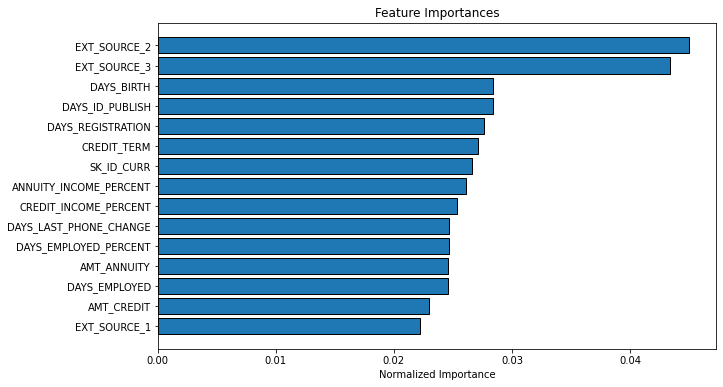

In [46]:
feature_importances_sorted=plot_feature_importances(feature_importances)

위에서 예상한 대로 EXT_SOURCE, DAYS_BIRTH 변수가 많은 영향을 주고 있음을 확인할 수 있다.

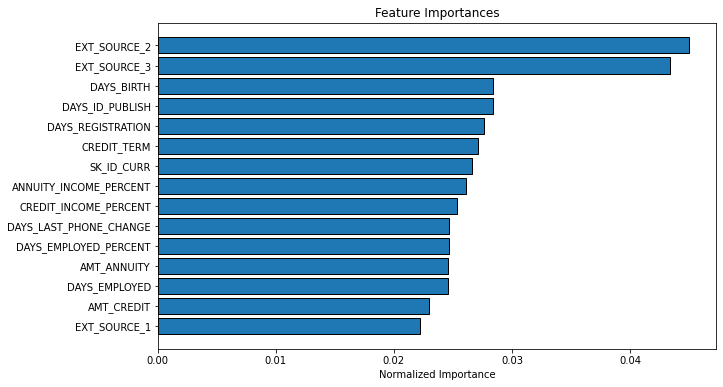

In [47]:
feature_importances_domain_sorted=plot_feature_importances(feature_importances_domain)

위에서 만들었던 새로운 지표 4개가 중요한 변수 15위에 모두 들어갔음을 볼 수 있다.

*  CREDIT_INCOME_PERCENT / ANNUITY_INCOME_PERCENT / CREDIT_TERM / DAYS_EMPLOYED_PERCENT




## 3. Light Gradient Boosting Machine

Light GBM 모델은 일반적으로 최고의 성능을 보이고, Kaggle 대회에서도 가장 많이 사용하고 있으므로 알아두는 것이 중요하다.

한번 Light GBM 모델을 만들어보자.

In [50]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [51]:
submission, fi, metrics=model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.541661	train's auc: 0.804531	valid's binary_logloss: 0.557281	valid's auc: 0.762577
Early stopping, best iteration is:
[237]	train's binary_logloss: 0.535426	train's auc: 0.810671	valid's binary_logloss: 0.553438	valid's auc: 0.762858
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542018	train's auc: 0.804304	valid's binary_logloss: 0.55808	valid's auc: 0.765594
Early stopping, best iteration is:
[227]	train's binary_logloss: 0.537574	train's auc: 0.808665	valid's binary_logloss: 0.555268	valid's auc: 0.765861
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542936	train's auc: 0.803753	valid's binary_logloss: 0.557892	valid's auc: 0.770139
[400]	train's binary_logloss: 0.511693	train's auc: 0.834338	valid's binary_logloss: 0.53839

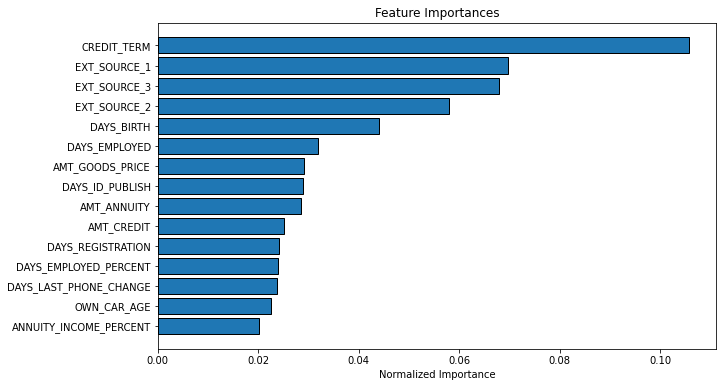

In [53]:
fi_sorted=plot_feature_importances(fi)

In [54]:
submission.to_csv('baseline_lgb.csv', index=False)

In [55]:
app_train_domain['TARGET']=train_labels

submission_domain, fi_domain, metrics_domain=model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.541661	train's auc: 0.804531	valid's binary_logloss: 0.557281	valid's auc: 0.762577
Early stopping, best iteration is:
[237]	train's binary_logloss: 0.535426	train's auc: 0.810671	valid's binary_logloss: 0.553438	valid's auc: 0.762858
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542018	train's auc: 0.804304	valid's binary_logloss: 0.55808	valid's auc: 0.765594
Early stopping, best iteration is:
[227]	train's binary_logloss: 0.537574	train's auc: 0.808665	valid's binary_logloss: 0.555268	valid's auc: 0.765861
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.542936	train's auc: 0.803753	valid's binary_logloss: 0.557892	valid's auc: 0.770139
[400]	train's binary_logloss: 0.511693	train's auc: 0.834338	valid's binary_logloss: 0.53839

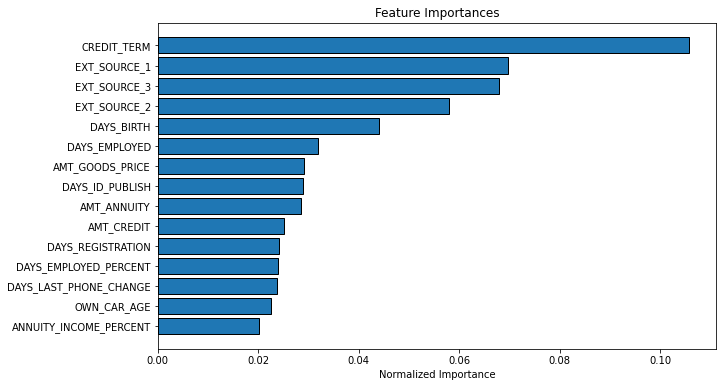

In [56]:
fi_sorted=plot_feature_importances(fi_domain)

여기서도 우리가 만들었던 4개의 변수가 중요한 변수에 속한다는 것을 확인할 수 있다.


*   CREDIT_INCOME_PERCENT / ANNUITY_INCOME_PERCENT / CREDIT_TERM / DAYS_EMPLOYED_PERCENT



In [57]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index=False)